# **A Hybrid Clinical Decision Support System for Mycetoma Diagnosis using Multimodal Deep Learning**
*Training*

## **Importing Libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Dense, Flatten, Dropout, Input, concatenate, Conv2D, GlobalAveragePooling2D,
    MaxPooling2D, BatchNormalization, RandomFlip, RandomRotation
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping
from PIL import Image
import joblib
import os
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **1. Synthetic Data Generation**

In [16]:
print("Generating realistic synthetic multimodal dataset...")
# Ensure the directory for synthetic images exists
if not os.path.exists('synthetic_images'):
    os.makedirs('synthetic_images')
def generate_synthetic_image(is_mycetoma, img_size=(128, 128), filename=''):
    """Generates a synthetic image with more complex features."""
    image = np.zeros((*img_size, 3), dtype=np.uint8)
    image += np.random.randint(0, 40, size=image.shape, dtype=np.uint8)
    cx, cy = np.random.randint(img_size[0]*0.2, img_size[0]*0.8), np.random.randint(img_size[1]*0.2, img_size[1]*0.8)
    if is_mycetoma:
        # Simulate a more irregular 'lesion' for mycetoma
        num_blotches = np.random.randint(3, 7)
        for _ in range(num_blotches):
            offset_x, offset_y = np.random.randint(-20, 20), np.random.randint(-20, 20)
            w, h = np.random.randint(15, 40), np.random.randint(15, 40)
            color = (np.random.randint(160, 240), np.random.randint(120, 180), np.random.randint(120, 180))
            image[cy+offset_y-h//2 : cy+offset_y+h//2, cx+offset_x-w//2 : cx+offset_x+w//2] = color
    else:
        # Simulate a smaller, more uniform feature for non-mycetoma
        w, h = np.random.randint(10, 25), np.random.randint(10, 25)
        color = (np.random.randint(90, 130), np.random.randint(90, 130), np.random.randint(90, 130))
        image[cy-h//2:cy+h//2, cx-w//2:cx+w//2] = color
    image = np.clip(image + np.random.randint(-15, 15, size=image.shape), 0, 255).astype(np.uint8)
    img = Image.fromarray(image, 'RGB')
    img.save(filename)
    return filename
# Generate clinical data and image paths
n_samples = 1000
image_paths = []
clinical_data = []
labels = []
for i in range(n_samples):
    is_mycetoma = np.random.choice([0, 1], p=[0.5, 0.5])
    if is_mycetoma:
        # Features for Mycetoma with more overlap
        age = np.random.normal(45, 12)
        duration_months = np.random.normal(20, 10)
        lesion_size_cm = np.random.normal(7, 3)
        pain_level_10 = np.random.randint(3, 8)
        labels.append(1)
    else:
        # Features for other conditions
        age = np.random.normal(55, 18)
        duration_months = np.random.normal(8, 6)
        lesion_size_cm = np.random.normal(4, 2)
        pain_level_10 = np.random.randint(5, 10)
        labels.append(0)
    clinical_data.append([age, duration_months, lesion_size_cm, pain_level_10])
    img_path = f"synthetic_images/img_{i}.png"
    generate_synthetic_image(is_mycetoma, filename=img_path)
    image_paths.append(img_path)
clinical_df = pd.DataFrame(clinical_data, columns=['age', 'duration_months', 'lesion_size_cm', 'pain_level'])
labels = np.array(labels)
print(f"Generated {n_samples} data points.")

Generating realistic synthetic multimodal dataset...


/tmp/ipython-input-3600178322.py:24: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  img = Image.fromarray(image, 'RGB')


Generated 1000 data points.


## **2. Data Preprocessing**

In [6]:
IMG_SIZE = 128
print("Preprocessing data and setting up augmentation...")
# Split data into training and testing sets
(train_clin_X, test_clin_X,
 train_img_paths, test_img_paths,
 train_y, test_y) = train_test_split(clinical_df, image_paths, labels, test_size=0.2, random_state=42, stratify=labels)
# Scale clinical data
scaler = StandardScaler()
train_clin_X_scaled = scaler.fit_transform(train_clin_X)
test_clin_X_scaled = scaler.transform(test_clin_X)
# Define an image augmentation pipeline to prevent overfitting
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.2),
])
# Image Data Loading Function
def load_and_preprocess_image(path, is_training=False):
    image = tf.io.read_file(path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    if is_training:
        image = data_augmentation(image)
    # Use MobileNetV2's specific preprocessing function
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    return image
# Function to create a multimodal tf.data.Dataset
def create_dataset(image_paths, clinical_data_scaled, labels, is_training=False):
    path_ds = tf.data.Dataset.from_tensor_slices(image_paths)
    image_ds = path_ds.map(lambda x: load_and_preprocess_image(x, is_training), num_parallel_calls=tf.data.AUTOTUNE)
    clinical_ds = tf.data.Dataset.from_tensor_slices(clinical_data_scaled.astype(np.float32))
    # Combine the two data sources into one
    multimodal_ds = tf.data.Dataset.zip((({"image_input": image_ds, "clinical_input": clinical_ds})))
    label_ds = tf.data.Dataset.from_tensor_slices(to_categorical(labels, num_classes=2))
    final_ds = tf.data.Dataset.zip((multimodal_ds, label_ds))
    return final_ds.batch(32).prefetch(tf.data.AUTOTUNE)
train_ds = create_dataset(train_img_paths, train_clin_X_scaled, train_y, is_training=True)
test_ds = create_dataset(test_img_paths, test_clin_X_scaled, test_y)
print("Data preprocessing complete.")

Preprocessing data and setting up augmentation...
Data preprocessing complete.


## **3. Hybrid Model Building**

In [7]:
print("Building the hybrid deep learning model...")

Building the hybrid deep learning model...


### Vision Layer (CNN)

In [8]:
base_model = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')
base_model.trainable = False
vision_input = Input(shape=(IMG_SIZE, IMG_SIZE, 3), name='image_input')
x = base_model(vision_input, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
vision_branch = Dense(64, activation='relu')(x)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


### Clinical Branch (MLP)

In [9]:
clinical_input = Input(shape=(train_clin_X_scaled.shape[1],), name='clinical_input')
y = Dense(32, activation='relu')(clinical_input)
y = Dropout(0.3)(y)
clinical_branch = Dense(16, activation='relu')(y)

### Fusion Layer

In [10]:
fused = concatenate([vision_branch, clinical_branch])
fused_dense = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(fused)
fused_dense = Dropout(0.5)(fused_dense)
output = Dense(2, activation='softmax', name='output')(fused_dense)

### Create and compile the model

In [11]:
hybrid_model = Model(inputs=[vision_input, clinical_input], outputs=output)

hybrid_model.compile(optimizer=Adam(learning_rate=0.001),
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])
hybrid_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mobilenetv2_1.00_1… │ (None, 4, 4,      │  2,257,984 │ image_input[0][0] │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ clinical_input      │ (None, 4)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ mobilenetv2_1.00… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │        160 │ clinical_input[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 1280)      │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │     81,984 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 16)        │        528 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 80)        │          0 │ dense[0][0],      │
│ (Concatenate)       │                   │            │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │      5,184 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 2)         │        130 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,345,970 (8.95 MB)

 Trainable params: 87,986 (343.70 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## **4. Model Training**

In [12]:
print("\nTraining the model with Early Stopping...")
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)
history = hybrid_model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=50,
    callbacks=[early_stopping],
    verbose=1
)
print("Model training complete.")


Training the model with Early Stopping...
Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 18s 836ms/step - accuracy: 0.6211 - loss: 1.4971 - val_accuracy: 1.0000 - val_loss: 0.7794
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 487ms/step - accuracy: 0.9430 - loss: 0.8339 - val_accuracy: 1.0000 - val_loss: 0.6246
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 627ms/step - accuracy: 0.9878 - loss: 0.6399 - val_accuracy: 1.0000 - val_loss: 0.5596
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 473ms/step - accuracy: 0.9814 - loss: 0.5817 - val_accuracy: 1.0000 - val_loss: 0.5083
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 662ms/step - accuracy: 0.9985 - loss: 0.5078 - val_accuracy: 1.0000 - val_loss: 0.4609
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 516ms/step - accuracy: 0.9963 - loss: 0.4618 - val_accuracy: 1.0000 - val_loss: 0.4181
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 629ms/step - accuracy: 0.9968 - loss: 0.4288 - val_accuracy: 1.0000 - val_loss: 0.3796
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 491ms/step - accura

## **5. Model Evaluation**


Evaluating the model...
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step

Classification Report:
              precision    recall  f1-score   support

Non-Mycetoma       1.00      1.00      1.00        54
    Mycetoma       1.00      1.00      1.00        46

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100

Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
ROC-AUC Score: 1.0000


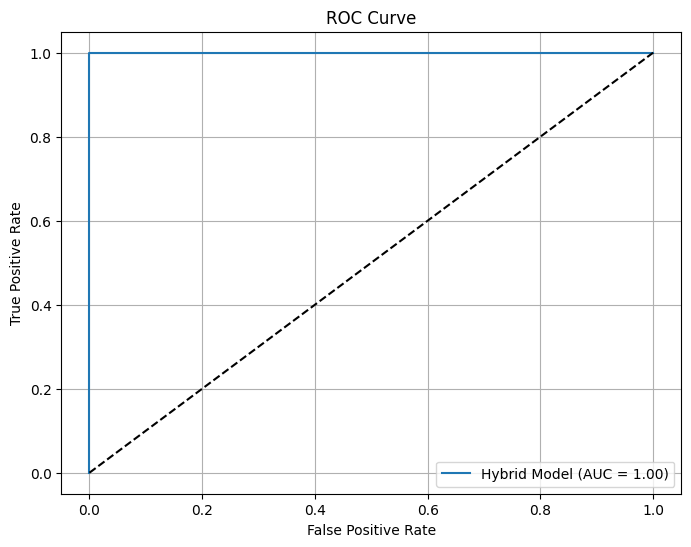

In [13]:
print("\nEvaluating the model...")
y_pred_proba = hybrid_model.predict(test_ds)
y_pred = np.argmax(y_pred_proba, axis=1)
print("\nClassification Report:")
print(classification_report(test_y, y_pred, target_names=['Non-Mycetoma', 'Mycetoma']))
# Calculate metrics
accuracy = accuracy_score(test_y, y_pred)
precision = precision_score(test_y, y_pred)
recall = recall_score(test_y, y_pred)
roc_auc = roc_auc_score(test_y, y_pred_proba[:, 1])
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")
#ROC-AUC
fpr, tpr, _ = roc_curve(test_y, y_pred_proba[:, 1])
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Hybrid Model (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [14]:
drive.mount('/content/drive')
save_path = '/content/drive/My Drive/Project 2/'
os.makedirs(save_path, exist_ok=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **6. Save Model and Scaler**

In [15]:
hybrid_model.save(os.path.join(save_path, 'mycetoma_hybrid_model.h5'))
joblib.dump(scaler, os.path.join(save_path, 'clinical_data_scaler.joblib'))
print("Model and scaler saved successfully to Google Drive.")

Model and scaler saved successfully to Google Drive.
